In [95]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn

%matplotlib inline

In [220]:
data = pd.read_csv(r'../../output/metrics-size.csv')
df = pd.DataFrame(data)
df['title'] = df['level_0']
attack_series = []
attack_IDs = []
dimensions_series = []
for _, row in df.iterrows():
    attack_series.append(row['level_1'].split('/')[-2])

df['attack'] = attack_series

for _, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))
    dimensions_series.append(dimension)
    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

df['attack_ID'] = attack_IDs
df['dimension'] = dimensions_series
df = df.drop(['Unnamed: 0',
         'temporal_canny-series',
         'temporal_cross_correlation-series', 
         'temporal_difference-series', 
         'temporal_histogram_distance-series', 
         'temporal_histogram_distance-cosine',
         'level_0', 
#           'dimension',
#           'temporal_canny-cosine',
#           'temporal_cross_correlation-cosine',
#               'temporal_difference-cosine',
         'level_1'],axis=1)

In [170]:
# There were some errors when calculatin metrics, so we add just the dct euclidean
new_data = pd.read_csv(r'../../output/metrics.csv')
new_df = pd.DataFrame(new_data)
df['temporal_dct-euclidean'] = new_df['temporal_dct-euclidean']

In [171]:
df.head(5)

,size,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,title,attack,attack_ID,dimension,temporal_dct-euclidean
0,6577213,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p,1,1080,0.000000
1,6571945,0.000566,0.670932,7.154334e-07,0.186423,0.000021,0.585142,0.587441,78.516691,../../data/1080p/-8ygLPzgpsg.mp4,1080p_watermark,0,1080,8.635463
2,6565814,0.001139,1.866004,5.874493e-04,3.274284,0.000036,0.361467,0.048735,3.019776,../../data/1080p/-8ygLPzgpsg.mp4,1080p_flip_vertical,0,1080,305.506033
3,6605114,0.001072,1.812684,8.232710e-04,4.191308,0.000043,0.403333,0.091211,1.929483,../../data/1080p/-8ygLPzgpsg.mp4,1080p_rotate_90_clockwise,0,1080,301.845087
4,6184965,0.000633,0.630162,8.913559e-07,0.385323,0.000296,1.154801,11.787850,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_vignette,0,1080,316.323724


In [172]:
df.describe()

,size,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension,temporal_dct-euclidean
count,5.796000e+03,5796.000000,5796.000000,5.796000e+03,5796.000000,5796.000000,5796.000000,5796.000000,3174.000000,5796.000000,5796.000000,5796.000000
mean,1.388829e+06,0.124845,12196.617817,2.942489e-03,1.671773,0.021534,3.302123,5.355903,40.343494,0.142857,504.000000,131.977121
std,1.647131e+06,0.246705,50237.227818,1.237253e-02,2.582384,0.070417,2.904630,9.728277,40.267544,0.349957,316.001944,157.233553
min,1.569200e+04,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.000000,0.000000
25%,2.485300e+05,0.000873,1.099166,3.474633e-07,0.103534,0.000725,1.348963,0.165798,1.475565,0.000000,240.000000,6.003078
50%,7.122165e+05,0.003933,3.552987,4.852876e-06,0.352134,0.003272,2.496744,0.604480,9.992767,0.000000,420.000000,77.553451
75%,1.793898e+06,0.090100,12.470781,3.877885e-04,2.447800,0.013115,4.241309,5.357450,84.832563,0.000000,720.000000,217.678630
max,9.821174e+06,0.974069,378978.958427,1.665425e-01,12.605094,0.823593,22.774383,56.174166,99.590587,1.000000,1080.000000,1080.873503


In [173]:
df_corr = df.corr()
plt.figure(figsize=(10,10))
corr = df_corr.corr('spearman')
corr.style.background_gradient().set_precision(2)

,size,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension,temporal_dct-euclidean
size,1,-0.45,-0.41,0.45,0.42,-0.94,-0.9,-0.36,-0.52,0.07,0.87,0.45
temporal_canny-cosine,-0.45,1,0.89,0.25,0.21,0.57,0.35,0.19,-0.13,-0.31,-0.31,0.27
temporal_canny-euclidean,-0.41,0.89,1,0.15,0.23,0.6,0.36,0.24,-0.14,-0.33,-0.37,0.25
temporal_cross_correlation-cosine,0.45,0.25,0.15,1,0.92,-0.44,-0.59,-0.48,-0.93,-0.41,0.52,0.73
temporal_cross_correlation-euclidean,0.42,0.21,0.23,0.92,1,-0.41,-0.5,-0.33,-0.95,-0.54,0.41,0.85
temporal_difference-cosine,-0.94,0.57,0.6,-0.44,-0.41,1,0.8,0.29,0.52,0.021,-0.81,-0.44
temporal_difference-euclidean,-0.9,0.35,0.36,-0.59,-0.5,0.8,1,0.66,0.57,-0.24,-0.94,-0.34
temporal_histogram_distance-euclidean,-0.36,0.19,0.24,-0.48,-0.33,0.29,0.66,1,0.38,-0.29,-0.57,-0.028
vmaf,-0.52,-0.13,-0.14,-0.93,-0.95,0.52,0.57,0.38,1,0.53,-0.5,-0.8
attack_ID,0.07,-0.31,-0.33,-0.41,-0.54,0.021,-0.24,-0.29,0.53,1,0.27,-0.73


<Figure size 720x720 with 0 Axes>

In [221]:
train_prop = 0.8

df_1 = df[df['attack_ID'] == 1]
df_0 = df[df['attack_ID'] == 0]


num_train = int(df_1.shape[0]*0.8)
df_train = df_1[0:num_train]
df_test = df_1[num_train:]
df_attacks = df_0

df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
df_attacks = df_attacks.sample(frac=1)

X_train = df_train.drop(['title',
                         'attack', 
                         'attack_ID',
                         'dimension',
                         'vmaf'],axis=1)
X_train = np.asarray(X_train)

X_test = df_test.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'dimension',  
                     'vmaf'],axis=1)
X_test = np.asarray(X_test)

X_attacks = df_attacks.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'dimension',
                     'vmaf'],axis=1)

X_attacks = np.asarray(X_attacks)

print('Shape of train: {}'.format(X_train.shape))
print('Shape of test: {}'.format(X_test.shape))
print('Shape of attacks: {}'.format(X_attacks.shape))


Shape of train: (662, 8)
Shape of test: (166, 8)
Shape of attacks: (4968, 8)


Text(0, 0.5, 'Explained variance')

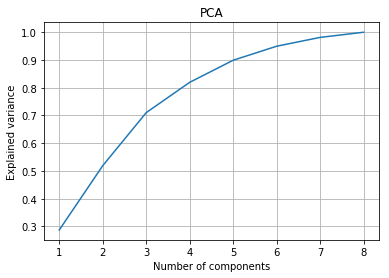

In [222]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

x_train = ss.fit_transform(X_train)
x_test = ss.transform(X_test)
x_attacks = ss.transform(X_attacks)

variances = []
components = reversed(range(1,x_test.shape[1]+1))
for i in components:
    pca = PCA(n_components=i)
    pca.fit(x_train)
    variances.append(sum(pca.explained_variance_ratio_))
plt.plot(list(reversed(range(1,x_test.shape[1]+1))), variances)   
plt.grid()
plt.title('PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [223]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


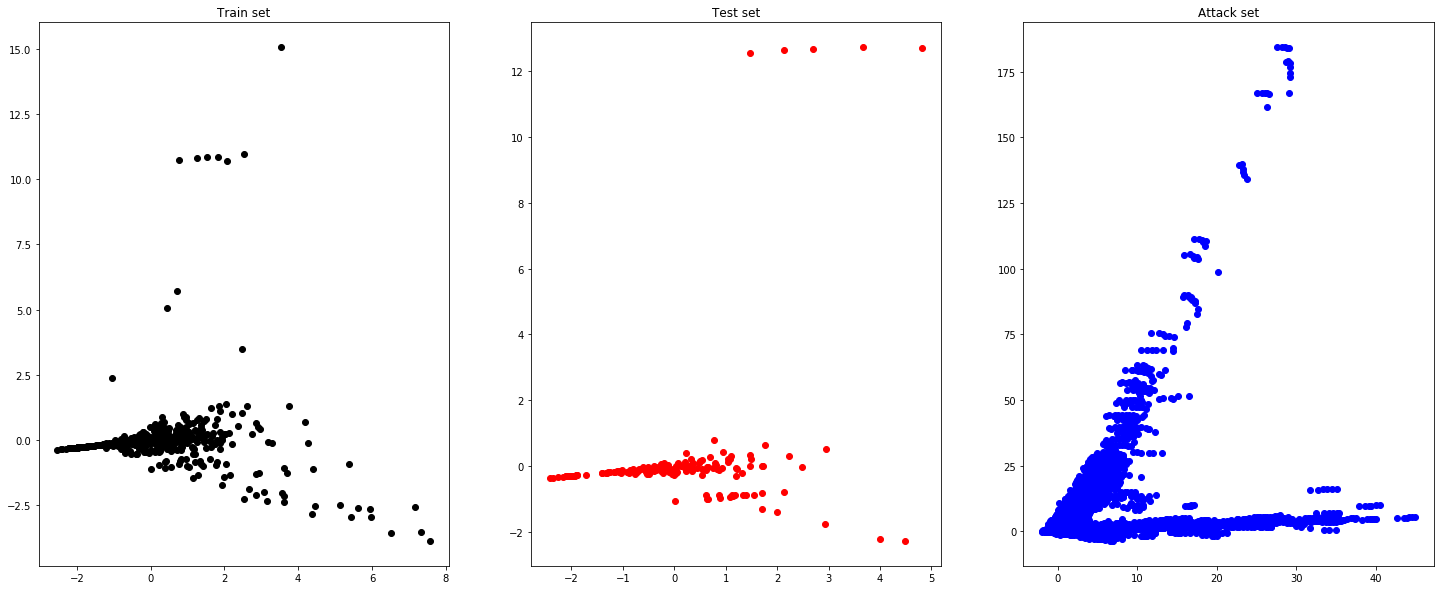

In [224]:
f, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].set_title("Train set")
ax[1].set_title("Test set")
ax[2].set_title("Attack set")
ax[0].scatter(X_reduced[:,0], X_reduced[:,1], color='black')
ax[1].scatter(test_reduced[:,0], test_reduced[:,1], color='red')
ax[2].scatter(attack_reduced[:,0], attack_reduced[:,1], color='blue')

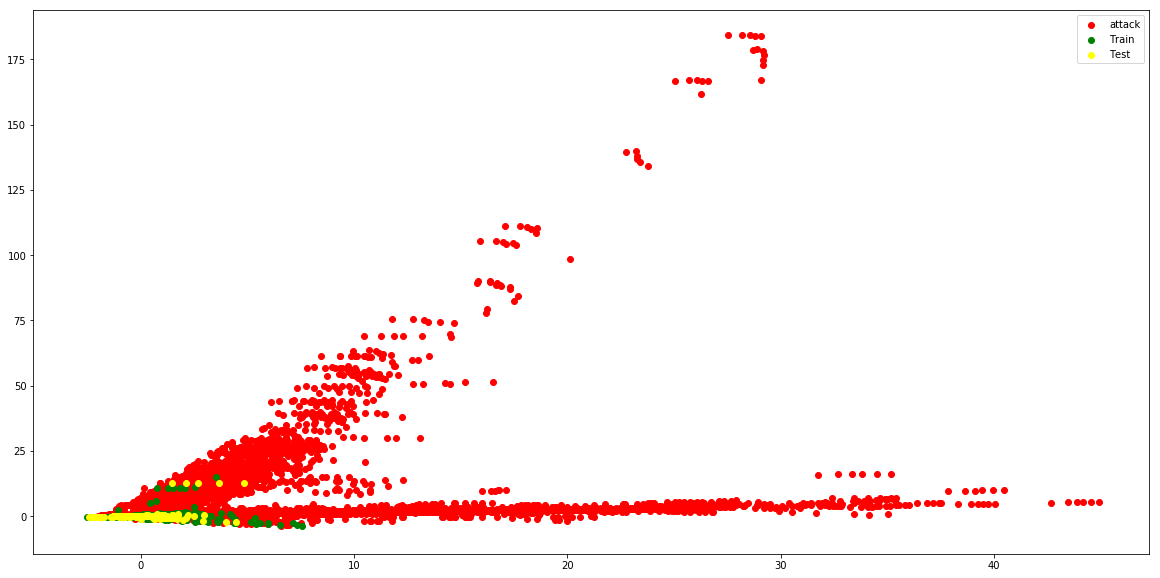

In [225]:
plt.figure(figsize=(20,10))
plt.scatter(attack_reduced[:,0], attack_reduced[:,1], color='red', label='attack')
plt.scatter(X_reduced[:,0], X_reduced[:,1], color='green', label='Train')
plt.scatter(test_reduced[:,0], test_reduced[:,1], color='yellow', label='Test')
plt.legend()


# One Class SVM

In [179]:
from sklearn import metrics 

nus = [0.1, 0.01, 0.001, 0.0001]

svm_results = pd.DataFrame(columns=['gamma', 'nu', 'n_components', 'TPR_train', 
                                    'TPR_test', 'TNR', 'model', 'auc', 'f_beta'])
for n in reversed(range(1,x_test.shape[1]+1)):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(x_train)
    test_reduced = pca.transform(x_test)
    attack_reduced = pca.transform(x_attacks)

    gammas = [X_reduced.shape[1], 2*X_reduced.shape[1], X_reduced.shape[1]/2, 'auto']                                 
    for nu in nus:
        for gamma in gammas:
            classifier = svm.OneClassSVM(kernel='rbf',gamma=gamma, nu=nu, cache_size=5000)
            classifier.fit(X_reduced)
            y_pred_train = classifier.predict(X_reduced)
            y_pred_test = classifier.predict(test_reduced)
            y_pred_outliers = classifier.predict(attack_reduced)
            n_accurate_train = y_pred_train[y_pred_train == 1].size
            n_accurate_test = y_pred_test[y_pred_test == 1].size
            n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size
            
            
            fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
            fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)
            
            svm_results = svm_results.append({'nu': nu, 'gamma': gamma, 'n_components': n, 'TPR_train': n_accurate_train/X_reduced.shape[0],
                           'TPR_test': n_accurate_test/test_reduced.shape[0], 'TNR': n_accurate_outliers/attack_reduced.shape[0],
                           'model': 'svm', 'auc': metrics.auc(fpr, tpr), 'f_beta': fb}, ignore_index=True)


/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ig

In [180]:
svm_results.sort_values('f_beta', ascending=False).head(10)

,gamma,nu,n_components,TPR_train,TPR_test,TNR,model,auc,f_beta
103,auto,0.010,3,0.963746,0.951807,0.751409,svm,0.851608,0.934580
119,auto,0.010,2,0.972810,0.951807,0.742552,svm,0.847180,0.933974
91,auto,0.001,4,0.951662,0.927711,0.810990,svm,0.869351,0.914969
87,auto,0.010,4,0.960725,0.927711,0.809581,svm,0.868646,0.914874
107,auto,0.001,3,0.954683,0.927711,0.752818,svm,0.840264,0.911068
115,auto,0.100,2,0.900302,0.921687,0.766707,svm,0.844197,0.906088
75,auto,0.001,5,0.948640,0.915663,0.826288,svm,0.870975,0.904131
71,auto,0.010,5,0.963746,0.909639,0.824074,svm,0.866856,0.898050
7,auto,0.010,9,0.959215,0.909639,0.815217,svm,0.862428,0.897464
130,0.5,0.100,1,0.915408,0.909639,0.764291,svm,0.836965,0.894111


In [107]:
svm_results.sort_values('auc', ascending=False).head(20)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f_beta
96,2,0.1000,2,0.892749,0.892749,0.795491,svm,0.855577,0.902084
55,auto,0.0100,5,0.966767,0.966767,0.759662,svm,0.849710,0.923336
51,auto,0.1000,5,0.900302,0.900302,0.807166,svm,0.849366,0.879151
63,auto,0.0001,5,0.879154,0.879154,0.794485,svm,0.849050,0.890175
70,2,0.0100,4,0.894260,0.894260,0.861916,svm,0.846621,0.823188
66,2,0.1000,4,0.888218,0.888218,0.861312,svm,0.846319,0.823151
59,auto,0.0010,5,0.962236,0.962236,0.757850,svm,0.845793,0.917309
98,1,0.1000,2,0.898792,0.898792,0.771739,svm,0.843701,0.900511
99,auto,0.1000,2,0.898792,0.898792,0.763688,svm,0.839675,0.899979
102,1,0.0100,2,0.953172,0.953172,0.735105,svm,0.837432,0.921676


In [ ]:
# Let's create a metric in order to find a best model from that metric
# We will get just accuracies from test y attack above 0.7, and will add them

In [ ]:
def metric(row, th=0.7):
    if row['test_acc'] < th or row['attack_acc'] < th:
        return 0
    else:
        return row['test_acc'] + row['attack_acc']

In [ ]:
svm_results['score'] = svm_results.apply(metric, axis=1)

In [ ]:
svm_results[svm_results['test_acc'] > svm_results['attack_acc']].sort_values('score', ascending=False).head(10)

# Isolation Forest

In [182]:
from sklearn.ensemble import IsolationForest

estimators = [100, 150, 200]
contaminations = [0.01]
isolation_results = pd.DataFrame(columns=['estimators', 'contamination', 'n_components', 'max_features',
                                          'TPR_test','TPR_train' , 'TNR', 'model', 'auc', 'f_beta'])
for n in reversed(range(1,x_test.shape[1]+1)):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(x_train)
    test_reduced = pca.transform(x_test)
    attack_reduced = pca.transform(x_attacks)
    max_features = list(range(1, n + 1))
    for estimator in estimators:
        for contamination in contaminations:
            for max_feature in max_features:
                classifier = IsolationForest(n_estimators=estimator,
                                             contamination=contamination,
                                             max_features=max_feature,
                                            n_jobs=5)
                
                classifier.fit(X_reduced)
                y_pred_train = classifier.predict(X_reduced)
                y_pred_test = classifier.predict(test_reduced)
                y_pred_outliers = classifier.predict(attack_reduced)
                n_error_train = y_pred_train[y_pred_train == 1].size
                n_error_test = y_pred_test[y_pred_test == 1].size
                n_error_outliers = y_pred_outliers[y_pred_outliers == -1].size
                
                fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
                
                fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)

                isolation_results = isolation_results.append({'estimators': estimator, 'contamination': contamination,
                                                              'n_components': n, 'max_features': max_feature,
                                                              'TPR_train': n_error_train/X_reduced.shape[0],
                                                              'TPR_test': n_error_train/X_reduced.shape[0],
                                                              'TNR': n_error_outliers/attack_reduced.shape[0],
                                                              'model': 'isolation_forest',
                                                              'auc': metrics.auc(fpr, tpr),
                                                              'f_beta': fb}, ignore_index=True)

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

In [138]:
isolation_results['score'] = isolation_results.apply(metric, axis=1)

NameError: name 'metric' is not defined

In [ ]:
isolation_results[isolation_results['test_acc'] > isolation_results['attack_acc']].sort_values('test_acc', ascending=False).head(10)

In [183]:
isolation_results.sort_values('f_beta', ascending=False).head(10)

,estimators,contamination,n_components,max_features,TPR_test,TPR_train,TNR,model,auc,f_beta
133,150,0.01,1,1,0.989426,0.989426,0.702496,isolation_forest,0.851248,0.978279
96,150,0.01,5,2,0.989426,0.989426,0.692432,isolation_forest,0.846216,0.977560
101,200,0.01,5,2,0.989426,0.989426,0.690620,isolation_forest,0.845310,0.977431
93,100,0.01,5,4,0.989426,0.989426,0.690217,isolation_forest,0.845109,0.977403
51,100,0.01,7,1,0.989426,0.989426,0.690016,isolation_forest,0.845008,0.977388
52,100,0.01,7,2,0.989426,0.989426,0.689815,isolation_forest,0.844907,0.977374
72,100,0.01,6,1,0.989426,0.989426,0.689815,isolation_forest,0.844907,0.977374
95,150,0.01,5,1,0.989426,0.989426,0.688808,isolation_forest,0.844404,0.977302
65,200,0.01,7,1,0.989426,0.989426,0.688205,isolation_forest,0.844102,0.977259
94,100,0.01,5,5,0.989426,0.989426,0.686795,isolation_forest,0.843398,0.977159


# Let's plot ROCs

In [140]:
def plot_roc(fpr, tpr, title):
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

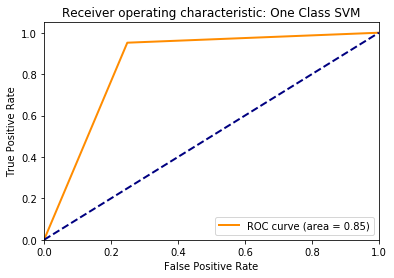

In [181]:
best_svm = svm_results.sort_values('f_beta', ascending=False).iloc[0]
pca = PCA(n_components=best_svm['n_components'])
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)
classifier = svm.OneClassSVM(kernel='rbf',gamma=best_svm['gamma'], nu=best_svm['nu'], cache_size=5000)
classifier.fit(X_reduced)

y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'One Class SVM')

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

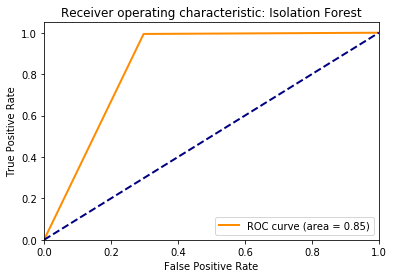

In [184]:
pca = PCA(n_components=1)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


classifier = IsolationForest(n_estimators=150,
                            contamination=0.01,
                            max_features=1,
                            n_jobs=5)
classifier.fit(X_reduced)
y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'Isolation Forest')

In [200]:
best_svm = svm_results.sort_values('f_beta', ascending=False).iloc[0]
pca = PCA(n_components=best_svm['n_components']-1)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)
classifier = svm.OneClassSVM(kernel='rbf',gamma=best_svm['gamma'], nu=best_svm['nu'], cache_size=5000)
# pca = PCA(n_components=1)
# X_reduced = pca.fit_transform(x_train)
# test_reduced = pca.transform(x_test)
# attack_reduced = pca.transform(x_attacks)


# classifier = IsolationForest(n_estimators=150,
#                             contamination=0.01,
#                             max_features=1,
#                             n_jobs=5)
classifier.fit(X_reduced)
classifier.fit(X_reduced)

OneClassSVM(cache_size=5000, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [201]:
y_pred_outliers = classifier.predict(attack_reduced)

In [202]:
df_attacks_reset = df_attacks.reset_index()

accurate_outliers_df = pd.DataFrame(y_pred_outliers, columns=['pred']) 
undetected = df_attacks_reset[accurate_outliers_df['pred'] == 1][['attack', 'title', 'dimension']]


In [203]:
undetected.groupby(['dimension', 'attack']).count()

title
dimension attack                      
144       144p_black_and_white       1
          144p_low_bitrate_4        56
          144p_watermark            78
240       240p_black_and_white       1
          240p_low_bitrate_4        96
          240p_watermark            96
360       360p_black_and_white       2
          360p_low_bitrate_4       121
          360p_watermark           111
480       480p_black_and_white       2
          480p_low_bitrate_4       129
          480p_watermark           113
720       720p_black_and_white       2
          720p_low_bitrate_4       133
          720p_watermark           113
1080      1080p_black_and_white      2
          1080p_low_bitrate_4      131
          1080p_watermark           92

In [204]:
undetected.groupby('title').count().sort_values(['attack'], ascending=False)

,attack,dimension
title,,
../../data/1080p/WVn8ckzvdOk.mp4,13,13
../../data/1080p/jJC1S1ZKuBk.mp4,12,12
../../data/1080p/Bj38r4-KgnU.mp4,12,12
../../data/1080p/njmmOzqDOiA.mp4,12,12
../../data/1080p/kjub25TsHCo.mp4,12,12
../../data/1080p/kFy8E_NiLY0.mp4,12,12
../../data/1080p/CY78yHv7LaU.mp4,12,12
../../data/1080p/pWtxt4YlI_A.mp4,12,12
../../data/1080p/C_ceO9OfKWY.mp4,12,12


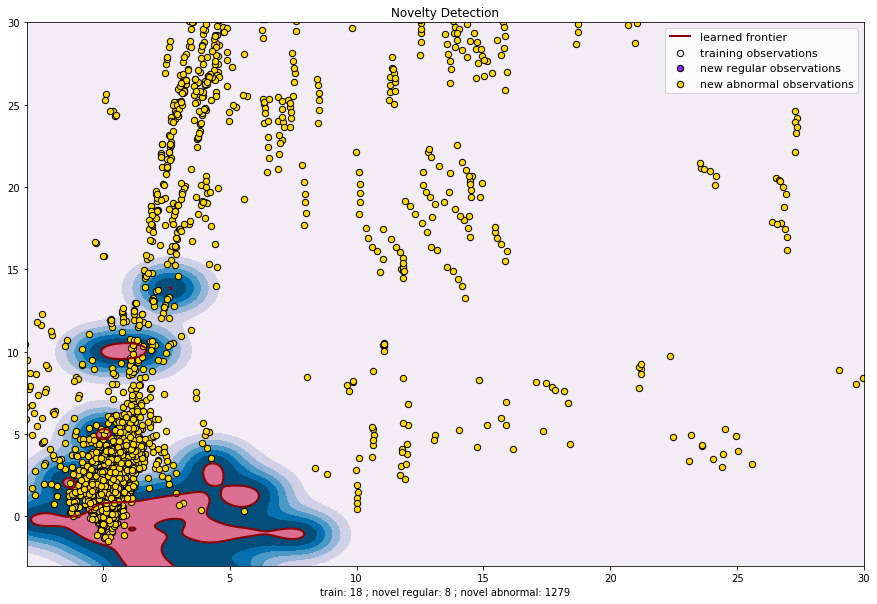

In [205]:
import matplotlib.font_manager

xx, yy = np.meshgrid(np.linspace(-3, 30, 500), np.linspace(-3, 30, 500))

y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,10))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
c = plt.scatter(attack_reduced[:, 1], attack_reduced[:, 0], c='gold', s=s,
                edgecolors='k')
b2 = plt.scatter(X_test[:, 1], X_test[:, 0], c='blueviolet', s=s,
                 edgecolors='k')

b1 = plt.scatter(X_train[:, 1], X_train[:, 0], c='white', s=s, edgecolors='k')

plt.axis('tight')
plt.xlim((-3, 30))
plt.ylim((-3, 30))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper right",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "train: %d ; novel regular: %d ; "
    "novel abnormal: %d"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# Conclusions

After the analysis made with the results of the best SVM, we have reached some interesting results:
* The attacks that pass through the system belong to the same attacks: watermarks and low bitrate
* The attacks that pass through the network do not belong to the same resolution

This means that we might be able to generalize into other attacks and resolutions

# Autoencoder

In [226]:
latent_dim = 3
input_vector = Input(shape=(X_train.shape[1],))
encoded = Dense(latent_dim, activation='relu')(input_vector)
decoded = Dense(X_train.shape[1], activity_regularizer=regularizers.l1(10e-5))(encoded)
autoencoder = Model(input_vector, decoded)
encoder = Model(input_vector, encoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
network_history = autoencoder.fit(x_train, x_train, shuffle=True, batch_size=16, epochs=100,
                                  validation_data=(x_test, x_test), verbose=True)


Train on 662 samples, validate on 166 samples
Epoch 1/100
662/662 [==============================] - 2s 2ms/step - loss: 1.3305 - val_loss: 2.0243
Epoch 2/100
662/662 [==============================] - 0s 675us/step - loss: 1.2302 - val_loss: 1.8546
Epoch 3/100
662/662 [==============================] - 0s 722us/step - loss: 1.1556 - val_loss: 1.7299
Epoch 4/100
662/662 [==============================] - 0s 684us/step - loss: 1.0989 - val_loss: 1.6336
Epoch 5/100
662/662 [==============================] - 0s 709us/step - loss: 1.0526 - val_loss: 1.5548
Epoch 6/100
662/662 [==============================] - 0s 727us/step - loss: 1.0135 - val_loss: 1.4678
Epoch 7/100
662/662 [==============================] - 1s 868us/step - loss: 0.9832 - val_loss: 1.4031
Epoch 8/100
662/662 [==============================] - 1s 762us/step - loss: 0.9546 - val_loss: 1.3564
Epoch 9/100
662/662 [==============================] - 0s 655us/step - loss: 0.9301 - val_loss: 1.3099
Epoch 10/100
662/662 [=======

662/662 [==============================] - 0s 660us/step - loss: 0.3330 - val_loss: 0.3530
Epoch 80/100
662/662 [==============================] - 1s 847us/step - loss: 0.3325 - val_loss: 0.3524
Epoch 81/100
662/662 [==============================] - 0s 729us/step - loss: 0.3322 - val_loss: 0.3503
Epoch 82/100
662/662 [==============================] - 1s 842us/step - loss: 0.3319 - val_loss: 0.3524
Epoch 83/100
662/662 [==============================] - 1s 773us/step - loss: 0.3312 - val_loss: 0.3499
Epoch 84/100
662/662 [==============================] - 1s 944us/step - loss: 0.3309 - val_loss: 0.3498
Epoch 85/100
662/662 [==============================] - 1s 1ms/step - loss: 0.3305 - val_loss: 0.3498
Epoch 86/100
662/662 [==============================] - 1s 944us/step - loss: 0.3301 - val_loss: 0.3493
Epoch 87/100
662/662 [==============================] - 1s 821us/step - loss: 0.3299 - val_loss: 0.3495
Epoch 88/100
662/662 [==============================] - 0s 699us/step - loss: 0

In [227]:
def plot_history(network_history,title='Autoencoder Loss'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.show()

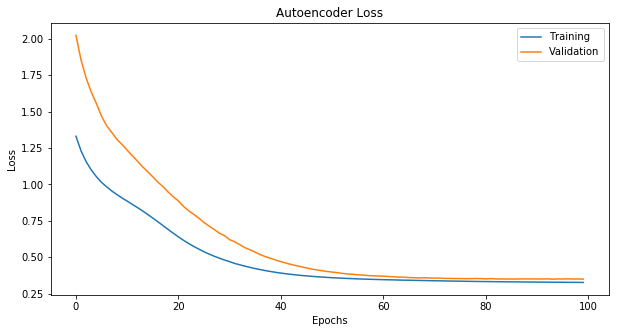

In [228]:
plot_history(network_history)

In [229]:
print('Mean loss on train: {}'.format(autoencoder.evaluate(x_train, x_train, batch_size=8, verbose=False)))
print('Mean loss on test: {}'.format(autoencoder.evaluate(x_test, x_test, batch_size=8, verbose=False)))
print('Mean loss on attacks: {}'.format(autoencoder.evaluate(x_attacks, x_attacks, batch_size=8, verbose=False)))

Mean loss on train: 0.32276774191064056
Mean loss on test: 0.3461179580674114
Mean loss on attacks: 92.57957234858699


In [230]:
x_train_pred = autoencoder.predict(x_train, batch_size=8)
x_test_pred = autoencoder.predict(x_test, batch_size=8)
x_attacks_pred = autoencoder.predict(x_attacks, batch_size=8)

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 5)

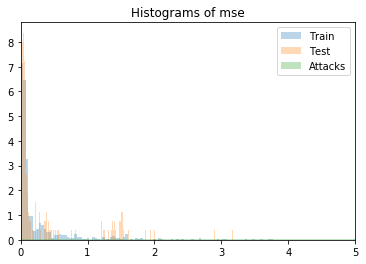

In [231]:
mse_train = (((x_train - x_train_pred)**2).mean(axis=1))
mse_test = (((x_test - x_test_pred)**2).mean(axis=1))
mse_attacks = (((x_attacks - x_attacks_pred)**2).mean(axis=1))

plt.figure()
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=200)

plt.hist(mse_train, **kwargs)
plt.hist(mse_test, **kwargs)
plt.hist(mse_attacks, **kwargs)
plt.legend(['Train', 'Test', 'Attacks'])
plt.title('Histograms of mse')
plt.xlim([0, 5])


In [232]:
x_train_red = encoder.predict(x_train, batch_size=8)
x_test_red = encoder.predict(x_test, batch_size=8)
x_attacks_red = encoder.predict(x_attacks, batch_size=8)

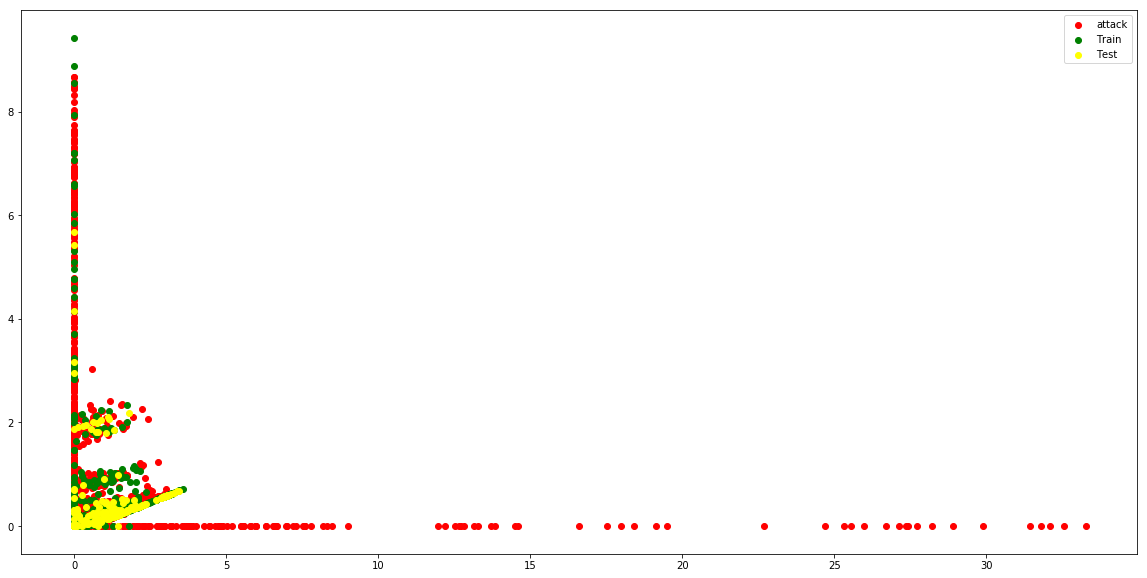

In [233]:
plt.figure(figsize=(20,10))
plt.scatter(x_attacks_red[:,0], x_attacks_red[:,1], color='red', label='attack')
plt.scatter(x_train_red[:,0], x_train_red[:,1], color='green', label='Train')
plt.scatter(x_test_red[:,0], x_test_red[:,1], color='yellow', label='Test')
plt.legend()

In [237]:
ae_svm_results = pd.DataFrame(columns=['gamma', 'nu', 'n_components', 'TPR_train', 
                                    'TPR_test', 'TNR', 'model', 'auc', 'f_beta'])

gammas = [x_train_red.shape[1], 2*x_train_red.shape[1], x_train_red.shape[1]/2, 'auto']                                 
for nu in nus:
    for gamma in gammas:
        classifier = svm.OneClassSVM(kernel='rbf',gamma=gamma, nu=nu, cache_size=5000)
        classifier.fit(X_reduced)
        y_pred_train = classifier.predict(X_reduced)
        y_pred_test = classifier.predict(test_reduced)
        y_pred_outliers = classifier.predict(attack_reduced)
        n_accurate_train = y_pred_train[y_pred_train == 1].size
        n_accurate_test = y_pred_test[y_pred_test == 1].size
        n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size


        fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                         -1*np.ones(y_pred_outliers.shape[0])]), 
                                          np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
        fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                         -1*np.ones(y_pred_outliers.shape[0])]), 
                                          np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)

        ae_svm_results = ae_svm_results.append({'nu': nu, 'gamma': gamma, 'n_components': n, 'TPR_train': n_accurate_train/X_reduced.shape[0],
                       'TPR_test': n_accurate_test/test_reduced.shape[0], 'TNR': n_accurate_outliers/attack_reduced.shape[0],
                       'model': 'ae-svm', 'auc': metrics.auc(fpr, tpr), 'f_beta': fb}, ignore_index=True)


In [238]:
ae_svm_results.sort_values('f_beta', ascending=False).head(10)

,gamma,nu,n_components,TPR_train,TPR_test,TNR,model,auc,f_beta
7,auto,0.0100,1,0.975831,0.969880,0.703301,ae-svm,0.836590,0.948938
15,auto,0.0001,1,0.954683,0.957831,0.715378,ae-svm,0.836605,0.938005
11,auto,0.0010,1,0.959215,0.957831,0.711353,ae-svm,0.834592,0.937729
6,1.5,0.0100,1,0.942598,0.927711,0.743760,ae-svm,0.835735,0.910463
2,1.5,0.1000,1,0.891239,0.915663,0.777375,ae-svm,0.846519,0.900884
3,auto,0.1000,1,0.897281,0.915663,0.763486,ae-svm,0.839574,0.899966
0,3,0.1000,1,0.879154,0.885542,0.805153,ae-svm,0.845348,0.873095
4,3,0.0100,1,0.900302,0.873494,0.788043,ae-svm,0.830769,0.860159
1,6,0.1000,1,0.874622,0.831325,0.812601,ae-svm,0.821963,0.820199
10,1.5,0.0010,1,0.868580,0.825301,0.797101,ae-svm,0.811201,0.813339


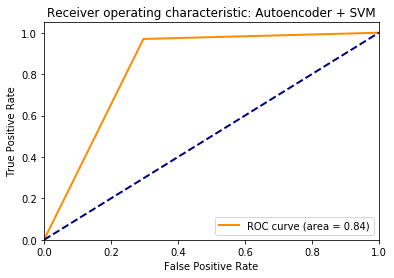

In [239]:
classifier = svm.OneClassSVM(kernel='rbf',gamma='auto', nu=0.01, cache_size=5000)
classifier.fit(X_reduced)
y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'Autoencoder + SVM')